In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import random
%matplotlib inline

In [3]:
def f_linear(m,b,x):
    """ Linear Function """
    return m*x+b
def f_parabola(a,b,c,x):
    """ parabola function """
    return  a*x**2.0 + b*x + c

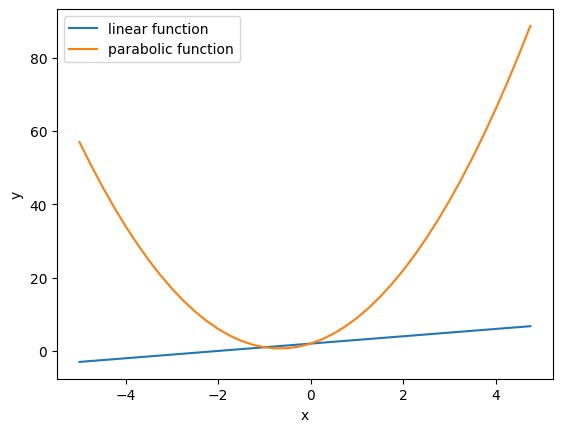

In [4]:
x = np.arange(-5,5,0.25)
yl = f_linear(1,2,x)
yp = f_parabola(3,4,2,x)
plt.plot(x,yl,label="linear function")
plt.plot(x,yp,label="parabolic function")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [5]:
h = 0.001
x = 3.0
f_parabola(3.0,4.0,2.0,x)

41.0

In [6]:
(f_parabola(3,4,2,x+h) -  f_parabola(3,4,2,x))/h

22.002999999997996

In [7]:
## more example
a = 2.0
b = -3.0
c = 10.0
h = 0.0001
d = a*b + c
da = (a+h)*b + c
db = a*(b+h) + c
dc = a*b + (c+h)

print("d : ",d)
print("da : ",da)
print("db : ",db)
print("dc : ",dc)

# slope
print("slope when a changes: ", (da - d)/h )
print("slope when b changes: ", (db - d)/h )
print("slope when c changes: ", (dc - d)/h )



d :  4.0
da :  3.999699999999999
db :  4.0002
dc :  4.0001
slope when a changes:  -3.000000000010772
slope when b changes:  2.0000000000042206
slope when c changes:  0.9999999999976694


# create core Value object

In [129]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self, other),"+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    
    def __neg__(self):
        return self * -1  
    def __sub__(self,other):
        return self + (-other)
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only support int and float in pow operation"
        out = Value(self.data**other,(self,),f"**{other}")

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self,other):
        return self * other**-1
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ),"tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ),"exp")
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        return out
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d, d._prev

(Value(data=4.0), {Value(data=-6.0), Value(data=10.0)})

## Visualization code

In [130]:

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    dot = Digraph(format="svg", graph_attr={'rankdir': "LR"}) #, node_attr={'rankdir': 'TB'})
    nodes, edges = trace(root)
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

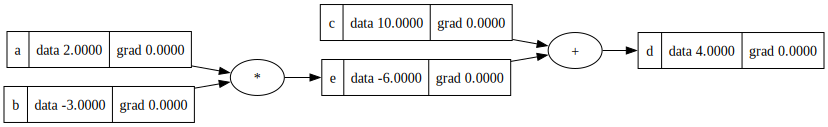

In [131]:
draw_dot(d)

## Back prop

In [132]:
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1*w1+x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = 'o'

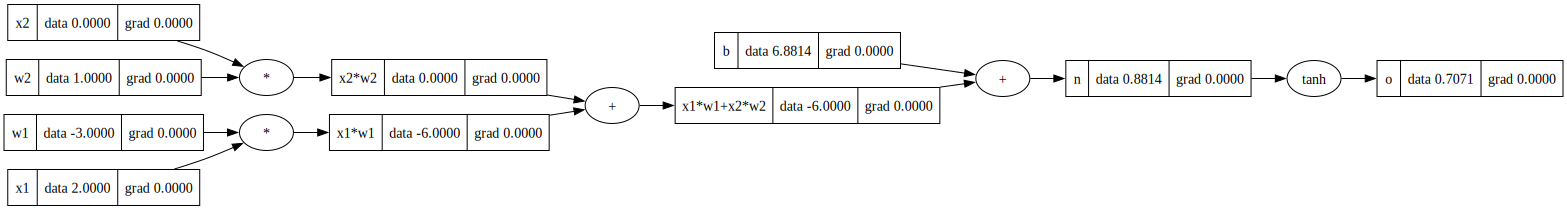

In [133]:
# before backprop
draw_dot(o)

In [134]:
# backpropogating
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

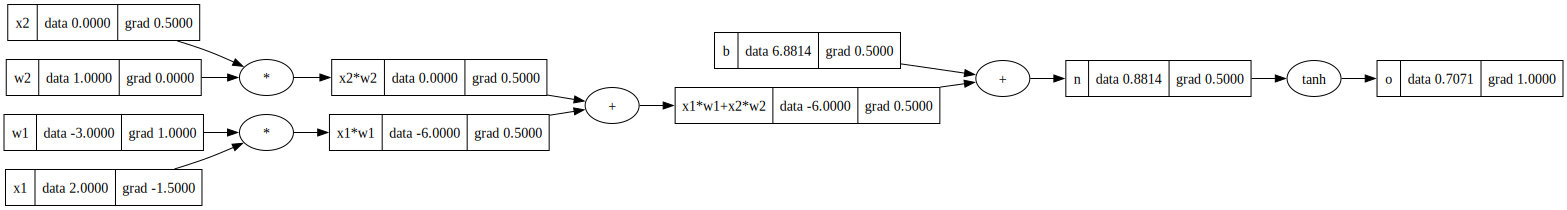

In [135]:
draw_dot(o)

In [136]:
## we can automate it
## add topological sort in backward function inside the Value
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1*w1+x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = 'o'


o.backward()

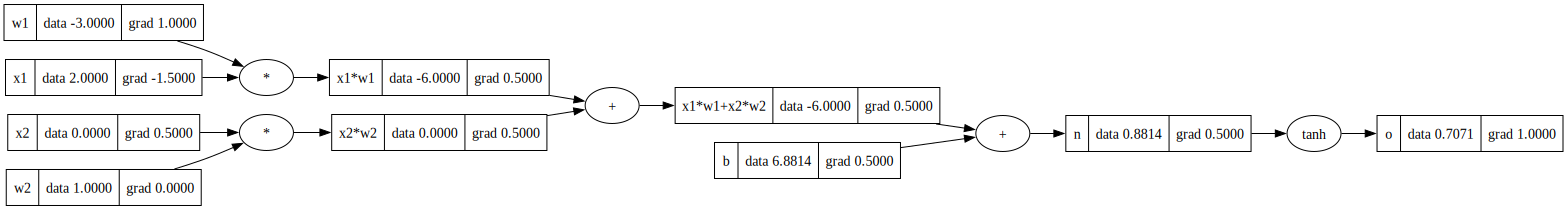

In [137]:
draw_dot(o)

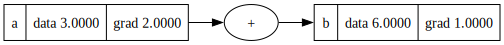

In [138]:
## multivariant bug issue
a = Value(3.0,label="a")
b = a + a; b.label="b"
b.backward()
draw_dot(b)
# the gradient is wrong
# """
# db/da = 1 + 1 = 2
# here the answer is 1

# so we need to accumilate the gradients
# """

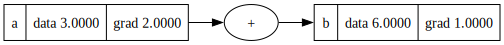

In [139]:
## after bug fixing
a = Value(3.0,label="a")
b = a + a; b.label="b"
b.backward()
draw_dot(b)

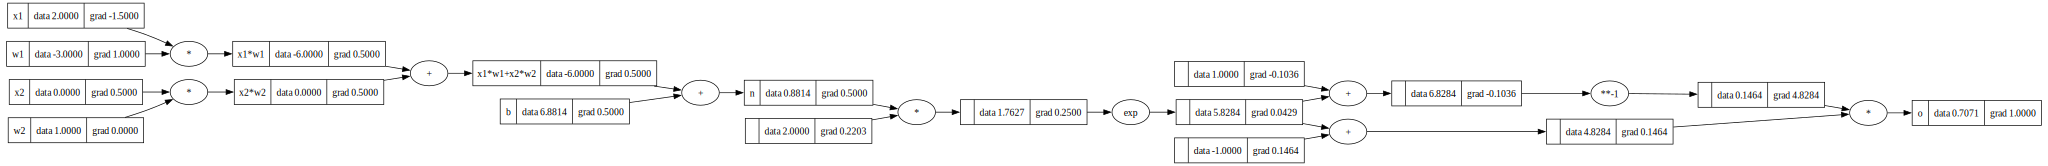

In [140]:
### breaking up tanh
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1*w1+x2*w2"
n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp()
o = (e - 1)/(e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [141]:
import torch

In [142]:
# currosponding torch implementation
### breaking up tanh
x1 = torch.tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double() ; w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print("*"*50)
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())



0.7071066904050358
**************************************************
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


## Building NN (multi-layer perceptron)
![drawing](..\imgs\multilayer_nn.jpeg)


In [143]:
class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = (Value(random.uniform(-1,1)))
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b) # = sum(xixi) + b
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self,nin,nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self,nin,nouts) -> None:
        sz = [nin] + nouts # total layer including the input layer and output layer
        self.layers =  [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
         
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.15309244560803076)

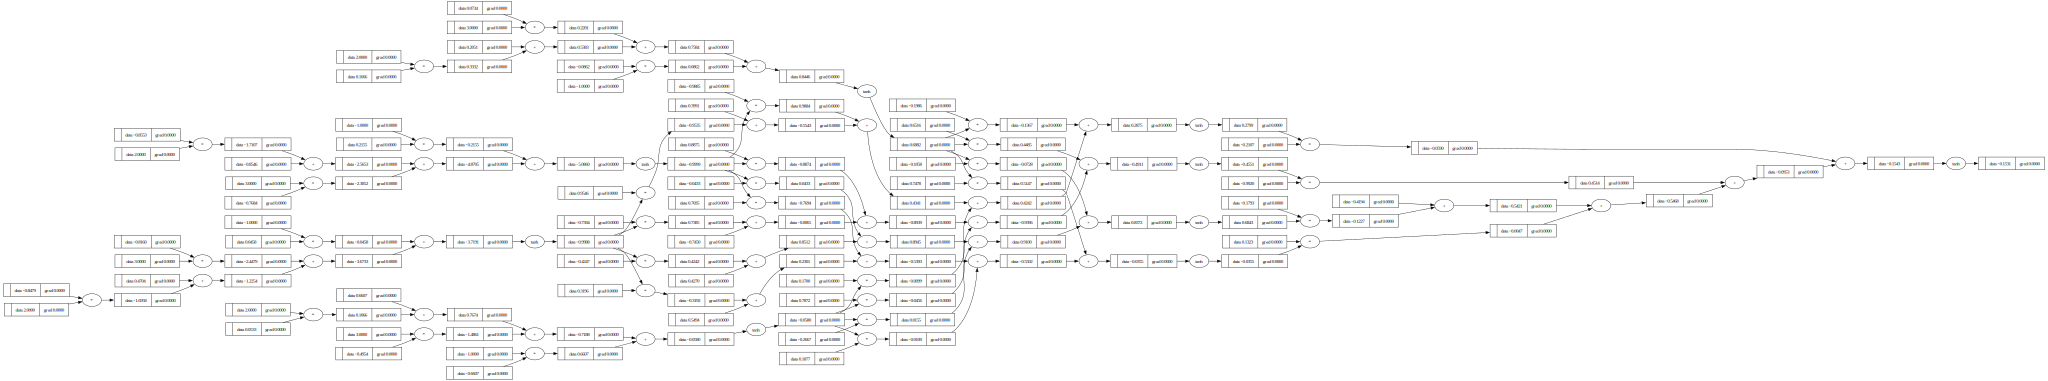

In [144]:
draw_dot(n(x))

In [153]:
## sample dataset
xs =[
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # true output

In [150]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9999215084525845),
 Value(data=0.9999222123013103),
 Value(data=0.9999384297909935),
 Value(data=0.9999463155084254)]

In [151]:
len(n.parameters())

41

In [154]:
# Training loop
epoch = 20
learning_rate = 0.05

# model initializion
n = MLP(3,[4,4,1])
for k in range(epoch):
    # do the forwards pass
    ypred = [n(x) for x in xs]
    # calculates loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
    # before the backwards pass set the zero grad ie: set all the gradients to zero
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update parameters: use gradient decent
    for p in n.parameters():
        p.data += -learning_rate * p.grad

    print(f'for epoch {k} : loss is {loss.data}')

for epoch 0 : loss is 6.101761218553828
for epoch 1 : loss is 2.390250934664494
for epoch 2 : loss is 0.7663914696899063
for epoch 3 : loss is 0.23017590635293822
for epoch 4 : loss is 0.12182856215856884
for epoch 5 : loss is 0.09178520244837202
for epoch 6 : loss is 0.07507616441866331
for epoch 7 : loss is 0.06399145074226471
for epoch 8 : loss is 0.055953223513588016
for epoch 9 : loss is 0.04979752444165179
for epoch 10 : loss is 0.044904938001473924
for epoch 11 : loss is 0.0409091850087312
for epoch 12 : loss is 0.037577113315194574
for epoch 13 : loss is 0.034752003778850016
for epoch 14 : loss is 0.032324000115416904
for epoch 15 : loss is 0.030213484219198866
for epoch 16 : loss is 0.028361162704848508
for epoch 17 : loss is 0.026721868114263303
for epoch 18 : loss is 0.025260528440908182
for epoch 19 : loss is 0.02394945930568866


In [156]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.917392225420011),
 Value(data=-0.9471379143797886),
 Value(data=-0.9142790373218799),
 Value(data=0.9238424958373554)]

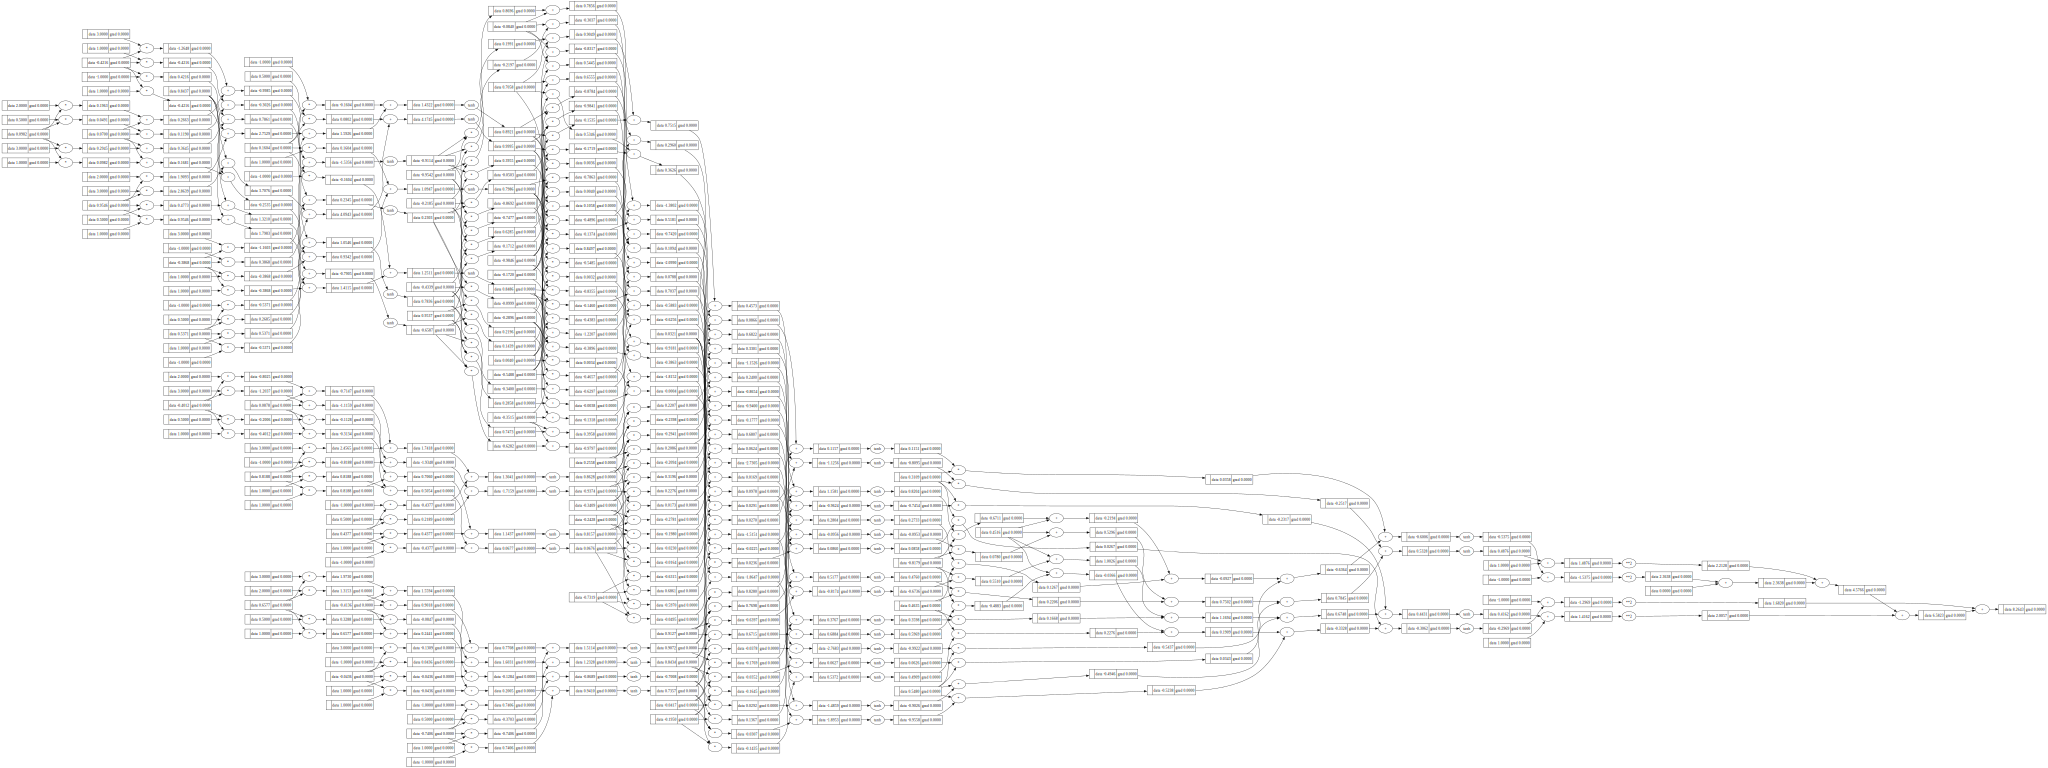

In [111]:
# draw_dot(loss)